In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens', 'random_occlusion', 'blur', 'original', 'gaussian_noise', 'lens_flare'}
Validation folders considered: {'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens', 'random_occlusion', 'blur', 'original', 'gaussian_noise', 'lens_flare'}
Test folders considered: {'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens', 'random_occlusion', 'blur', 'original', 'gaussian_noise', 'lens_flare'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens', 'blur', 'original', 'gaussian_noise', 'lens_flare'}
Validation folders considered: {'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens', 'blur', 'original', 'gaussian_noise', 'lens_flare'}
Test folders considered: {'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens', 'blur', 'original', 'gaussian_noise', 'lens_flare'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Fixed Xception Architecture from Scratch
# -----------------------------

class SeparableConv2d(nn.Module):
    """Depthwise Separable Convolution - Core of Xception"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=bias)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class XceptionBlock(nn.Module):
    """Fixed Xception Block with skip connections"""
    def __init__(self, in_channels, out_channels, reps, stride=1, start_with_relu=True, grow_first=True):
        super(XceptionBlock, self).__init__()
        
        # Skip connection if needed
        self.skip = None
        if out_channels != in_channels or stride != 1:
            self.skip = nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False)
            self.skipbn = nn.BatchNorm2d(out_channels)
        
        rep = []
        filters = in_channels
        
        if grow_first:
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(out_channels))
            filters = out_channels

        for i in range(reps - 1):
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(out_channels))

        if stride != 1:
            rep.append(nn.MaxPool2d(3, stride=stride, padding=1))
        
        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        output = self.rep(x)
        
        if self.skip is not None:
            skip = self.skip(x)
            skip = self.skipbn(skip)
        else:
            skip = x
        
        output += skip
        return output

class Xception(nn.Module):
    """Fixed Xception Network Architecture from Scratch"""
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=False)  # FIXED: inplace=False
        
        self.conv2 = nn.Conv2d(32, 64, 3, bias=False, padding=1)  # FIXED: added padding
        self.bn2 = nn.BatchNorm2d(64)
        
        self.block1 = XceptionBlock(64, 128, 2, stride=2, start_with_relu=False, grow_first=True)
        self.block2 = XceptionBlock(128, 256, 2, stride=2, start_with_relu=True, grow_first=True)
        self.block3 = XceptionBlock(256, 728, 2, stride=2, start_with_relu=True, grow_first=True)
        
        # Middle Flow (repeated 8 times)
        self.block4 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block5 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block6 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block7 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block8 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block9 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block10 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block11 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        
        # Exit Flow
        self.block12 = XceptionBlock(728, 1024, 2, stride=2, start_with_relu=True, grow_first=False)
        
        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(1536)
        
        self.conv4 = SeparableConv2d(1536, 2048, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(2048)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)
        
        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Entry Flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Middle Flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        
        # Exit Flow
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        # Final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# -----------------------------
# 2. Data Preprocessing with Filtering (Xception - 299x299)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# Xception training from scratch - with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation for scratch training
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

transform_val_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("🔄 Loading and filtering datasets for Xception (scratch training)...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform_train)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform_val_test)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform_val_test)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)  # Smaller batch for scratch training
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"✅ Classes: {classes}")
print(f"📊 Dataset Statistics:")
print(f"│ Training images: {len(train_ds)}")
print(f"│ Validation images: {len(val_ds)}")
print(f"│ Test images: {len(test_ds)}")
print(f"│ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"│ Excluded folder: '{ignore_folder}'")
print(f"│ Number of classes: {len(classes)}")

# -----------------------------
# 3. Model Setup for Scratch Training
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create Xception model from scratch
print("🔄 Creating Xception model from scratch...")
model = Xception(num_classes=len(classes))
model = model.to(device)

print(f"✅ Model created with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 299, 299)")
print(f"│ Xception features: 2048")
print(f"│ Output classes: {len(classes)}")
print(f"│ Training: From scratch (no pretrained weights)")
print(f"│ Data augmentation: Enabled for robust training")

🔄 Loading and filtering datasets for Xception (scratch training)...
✅ Classes: ['fast_bowl', 'spin_bowl']
📊 Dataset Statistics:
│ Training images: 1520
│ Validation images: 384
│ Test images: 488
│ Total images (after filtering): 2392
│ Excluded folder: 'random_occlusion'
│ Number of classes: 2
Using device: cuda
🔄 Creating Xception model from scratch...
✅ Model created with 2 output classes
📊 Total parameters: 20,811,050
📊 Trainable parameters: 20,811,050
📋 Model Architecture:
│ Input size: (3, 299, 299)
│ Xception features: 2048
│ Output classes: 2
│ Training: From scratch (no pretrained weights)
│ Data augmentation: Enabled for robust training



📋 Training Configuration:
│ Model: Xception (from scratch)
│ Optimizer: Adam (lr=0.001)
│ Weight Decay: 1e-4
│ Loss Function: CrossEntropyLoss
│ Batch Size: 16
│ LR Scheduler: StepLR (decay every 10 epochs)
│ Device: cuda
│ Data: Filtered + Augmented

🚀 Starting Xception Training from Scratch for 50 epochs...

📈 Epoch 1/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:17<00:00,  1.62s/it, Loss=0.7170, Acc=0.5888]


✅ Training completed in 77.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:08<00:00,  1.44it/s, Loss=0.6605, Acc=0.6250]


✅ Validation completed in 8.35s
🌟 New best model found! Validation Accuracy: 0.6250

📊 Epoch 1 Summary:
│ Train Loss: 0.7170 | Train Acc: 0.5888
│ Val Loss:   0.6605 | Val Acc:   0.6250
│ Train Time: 77.89s | Val Time: 8.35s
│ Total Epoch Time: 86.25s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 2/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.6962, Acc=0.6105]


✅ Training completed in 70.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.99it/s, Loss=0.8018, Acc=0.4792]


✅ Validation completed in 6.04s

📊 Epoch 2 Summary:
│ Train Loss: 0.6962 | Train Acc: 0.6105
│ Val Loss:   0.8018 | Val Acc:   0.4792
│ Train Time: 70.33s | Val Time: 6.04s
│ Total Epoch Time: 76.37s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 3/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6853, Acc=0.5961]


✅ Training completed in 70.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.6847, Acc=0.4635]


✅ Validation completed in 5.88s

📊 Epoch 3 Summary:
│ Train Loss: 0.6853 | Train Acc: 0.5961
│ Val Loss:   0.6847 | Val Acc:   0.4635
│ Train Time: 70.86s | Val Time: 5.88s
│ Total Epoch Time: 76.75s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 4/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6929, Acc=0.5934]


✅ Training completed in 70.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.9079, Acc=0.6250]


✅ Validation completed in 5.93s

📊 Epoch 4 Summary:
│ Train Loss: 0.6929 | Train Acc: 0.5934
│ Val Loss:   0.9079 | Val Acc:   0.6250
│ Train Time: 70.87s | Val Time: 5.93s
│ Total Epoch Time: 76.98s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 5/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6887, Acc=0.5855]


✅ Training completed in 70.83s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.6645, Acc=0.6250]


✅ Validation completed in 5.87s

📊 Epoch 5 Summary:
│ Train Loss: 0.6887 | Train Acc: 0.5855
│ Val Loss:   0.6645 | Val Acc:   0.6250
│ Train Time: 70.83s | Val Time: 5.87s
│ Total Epoch Time: 76.70s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 6/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6941, Acc=0.6020]


✅ Training completed in 70.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.8238, Acc=0.6250]


✅ Validation completed in 5.83s

📊 Epoch 6 Summary:
│ Train Loss: 0.6941 | Train Acc: 0.6020
│ Val Loss:   0.8238 | Val Acc:   0.6250
│ Train Time: 70.84s | Val Time: 5.83s
│ Total Epoch Time: 76.67s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 7/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6898, Acc=0.6013]


✅ Training completed in 70.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.9266, Acc=0.5495]


✅ Validation completed in 5.82s

📊 Epoch 7 Summary:
│ Train Loss: 0.6898 | Train Acc: 0.6013
│ Val Loss:   0.9266 | Val Acc:   0.5495
│ Train Time: 70.84s | Val Time: 5.82s
│ Total Epoch Time: 76.67s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 8/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.6870, Acc=0.6066]


✅ Training completed in 70.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.6601, Acc=0.6250]


✅ Validation completed in 5.87s

📊 Epoch 8 Summary:
│ Train Loss: 0.6870 | Train Acc: 0.6066
│ Val Loss:   0.6601 | Val Acc:   0.6250
│ Train Time: 70.65s | Val Time: 5.87s
│ Total Epoch Time: 76.52s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 9/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6714, Acc=0.6270]


✅ Training completed in 70.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.8444, Acc=0.6120]


✅ Validation completed in 5.88s

📊 Epoch 9 Summary:
│ Train Loss: 0.6714 | Train Acc: 0.6270
│ Val Loss:   0.8444 | Val Acc:   0.6120
│ Train Time: 70.87s | Val Time: 5.88s
│ Total Epoch Time: 76.75s
│ Best Val Acc: 0.6250 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 10/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.6692, Acc=0.6276]


✅ Training completed in 70.70s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.7166, Acc=0.6589]


✅ Validation completed in 5.80s
🌟 New best model found! Validation Accuracy: 0.6589

📊 Epoch 10 Summary:
│ Train Loss: 0.6692 | Train Acc: 0.6276
│ Val Loss:   0.7166 | Val Acc:   0.6589
│ Train Time: 70.70s | Val Time: 5.80s
│ Total Epoch Time: 76.51s
│ Best Val Acc: 0.6589 (Epoch 10)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 11/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.6453, Acc=0.6401]


✅ Training completed in 70.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.6445, Acc=0.6589]


✅ Validation completed in 5.89s

📊 Epoch 11 Summary:
│ Train Loss: 0.6453 | Train Acc: 0.6401
│ Val Loss:   0.6445 | Val Acc:   0.6589
│ Train Time: 70.67s | Val Time: 5.89s
│ Total Epoch Time: 76.57s
│ Best Val Acc: 0.6589 (Epoch 10)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 12/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.6230, Acc=0.6579]


✅ Training completed in 70.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.02it/s, Loss=0.6520, Acc=0.6484]


✅ Validation completed in 5.95s

📊 Epoch 12 Summary:
│ Train Loss: 0.6230 | Train Acc: 0.6579
│ Val Loss:   0.6520 | Val Acc:   0.6484
│ Train Time: 70.97s | Val Time: 5.95s
│ Total Epoch Time: 76.92s
│ Best Val Acc: 0.6589 (Epoch 10)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 13/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.5995, Acc=0.6947]


✅ Training completed in 70.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.6583, Acc=0.6615]


✅ Validation completed in 5.91s
🌟 New best model found! Validation Accuracy: 0.6615

📊 Epoch 13 Summary:
│ Train Loss: 0.5995 | Train Acc: 0.6947
│ Val Loss:   0.6583 | Val Acc:   0.6615
│ Train Time: 70.78s | Val Time: 5.91s
│ Total Epoch Time: 76.70s
│ Best Val Acc: 0.6615 (Epoch 13)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 14/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.5774, Acc=0.6993]


✅ Training completed in 70.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.02it/s, Loss=0.6959, Acc=0.6042]


✅ Validation completed in 5.95s

📊 Epoch 14 Summary:
│ Train Loss: 0.5774 | Train Acc: 0.6993
│ Val Loss:   0.6959 | Val Acc:   0.6042
│ Train Time: 70.80s | Val Time: 5.95s
│ Total Epoch Time: 76.76s
│ Best Val Acc: 0.6615 (Epoch 13)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 15/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.5833, Acc=0.6987]


✅ Training completed in 70.50s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.6476, Acc=0.6849]


✅ Validation completed in 5.89s
🌟 New best model found! Validation Accuracy: 0.6849

📊 Epoch 15 Summary:
│ Train Loss: 0.5833 | Train Acc: 0.6987
│ Val Loss:   0.6476 | Val Acc:   0.6849
│ Train Time: 70.50s | Val Time: 5.89s
│ Total Epoch Time: 76.40s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 16/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.5451, Acc=0.7276]


✅ Training completed in 70.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.7051, Acc=0.6589]


✅ Validation completed in 5.85s

📊 Epoch 16 Summary:
│ Train Loss: 0.5451 | Train Acc: 0.7276
│ Val Loss:   0.7051 | Val Acc:   0.6589
│ Train Time: 70.86s | Val Time: 5.85s
│ Total Epoch Time: 76.71s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 17/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.5298, Acc=0.7382]


✅ Training completed in 70.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.7263, Acc=0.6458]


✅ Validation completed in 5.80s

📊 Epoch 17 Summary:
│ Train Loss: 0.5298 | Train Acc: 0.7382
│ Val Loss:   0.7263 | Val Acc:   0.6458
│ Train Time: 70.82s | Val Time: 5.80s
│ Total Epoch Time: 76.62s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 18/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.5000, Acc=0.7618]


✅ Training completed in 70.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.7263, Acc=0.6276]


✅ Validation completed in 5.85s

📊 Epoch 18 Summary:
│ Train Loss: 0.5000 | Train Acc: 0.7618
│ Val Loss:   0.7263 | Val Acc:   0.6276
│ Train Time: 70.30s | Val Time: 5.85s
│ Total Epoch Time: 76.15s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 19/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.4670, Acc=0.7789]


✅ Training completed in 70.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.8148, Acc=0.5911]


✅ Validation completed in 5.91s

📊 Epoch 19 Summary:
│ Train Loss: 0.4670 | Train Acc: 0.7789
│ Val Loss:   0.8148 | Val Acc:   0.5911
│ Train Time: 70.53s | Val Time: 5.91s
│ Total Epoch Time: 76.44s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 20/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.4476, Acc=0.8013]


✅ Training completed in 70.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.9053, Acc=0.6328]


✅ Validation completed in 5.80s

📊 Epoch 20 Summary:
│ Train Loss: 0.4476 | Train Acc: 0.8013
│ Val Loss:   0.9053 | Val Acc:   0.6328
│ Train Time: 70.39s | Val Time: 5.80s
│ Total Epoch Time: 76.19s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 21/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.4112, Acc=0.8184]


✅ Training completed in 70.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.8393, Acc=0.6745]


✅ Validation completed in 5.82s

📊 Epoch 21 Summary:
│ Train Loss: 0.4112 | Train Acc: 0.8184
│ Val Loss:   0.8393 | Val Acc:   0.6745
│ Train Time: 70.37s | Val Time: 5.82s
│ Total Epoch Time: 76.19s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 22/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3915, Acc=0.8217]


✅ Training completed in 70.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.8494, Acc=0.6406]


✅ Validation completed in 5.81s

📊 Epoch 22 Summary:
│ Train Loss: 0.3915 | Train Acc: 0.8217
│ Val Loss:   0.8494 | Val Acc:   0.6406
│ Train Time: 70.47s | Val Time: 5.81s
│ Total Epoch Time: 76.29s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 23/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3953, Acc=0.8250]


✅ Training completed in 70.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.94it/s, Loss=0.8175, Acc=0.6562]


✅ Validation completed in 6.18s

📊 Epoch 23 Summary:
│ Train Loss: 0.3953 | Train Acc: 0.8250
│ Val Loss:   0.8175 | Val Acc:   0.6562
│ Train Time: 70.77s | Val Time: 6.18s
│ Total Epoch Time: 76.95s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 24/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:11<00:00,  1.48s/it, Loss=0.3738, Acc=0.8375]


✅ Training completed in 71.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.96it/s, Loss=0.8252, Acc=0.6641]


✅ Validation completed in 6.12s

📊 Epoch 24 Summary:
│ Train Loss: 0.3738 | Train Acc: 0.8375
│ Val Loss:   0.8252 | Val Acc:   0.6641
│ Train Time: 71.11s | Val Time: 6.12s
│ Total Epoch Time: 77.23s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 25/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3645, Acc=0.8395]


✅ Training completed in 70.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.8225, Acc=0.6745]


✅ Validation completed in 5.83s

📊 Epoch 25 Summary:
│ Train Loss: 0.3645 | Train Acc: 0.8395
│ Val Loss:   0.8225 | Val Acc:   0.6745
│ Train Time: 70.80s | Val Time: 5.83s
│ Total Epoch Time: 76.63s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 26/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.3594, Acc=0.8408]


✅ Training completed in 70.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.8320, Acc=0.6589]


✅ Validation completed in 5.91s

📊 Epoch 26 Summary:
│ Train Loss: 0.3594 | Train Acc: 0.8408
│ Val Loss:   0.8320 | Val Acc:   0.6589
│ Train Time: 70.85s | Val Time: 5.91s
│ Total Epoch Time: 76.76s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 27/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3528, Acc=0.8480]


✅ Training completed in 70.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.8089, Acc=0.6797]


✅ Validation completed in 5.92s

📊 Epoch 27 Summary:
│ Train Loss: 0.3528 | Train Acc: 0.8480
│ Val Loss:   0.8089 | Val Acc:   0.6797
│ Train Time: 70.71s | Val Time: 5.92s
│ Total Epoch Time: 76.63s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 28/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.3541, Acc=0.8546]


✅ Training completed in 70.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.02it/s, Loss=0.7939, Acc=0.6693]


✅ Validation completed in 5.94s

📊 Epoch 28 Summary:
│ Train Loss: 0.3541 | Train Acc: 0.8546
│ Val Loss:   0.7939 | Val Acc:   0.6693
│ Train Time: 70.85s | Val Time: 5.94s
│ Total Epoch Time: 76.79s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 29/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3561, Acc=0.8467]


✅ Training completed in 70.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.7930, Acc=0.6849]


✅ Validation completed in 5.85s

📊 Epoch 29 Summary:
│ Train Loss: 0.3561 | Train Acc: 0.8467
│ Val Loss:   0.7930 | Val Acc:   0.6849
│ Train Time: 70.68s | Val Time: 5.85s
│ Total Epoch Time: 76.53s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 30/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.3392, Acc=0.8592]


✅ Training completed in 70.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.00it/s, Loss=0.8036, Acc=0.6823]


✅ Validation completed in 6.01s

📊 Epoch 30 Summary:
│ Train Loss: 0.3392 | Train Acc: 0.8592
│ Val Loss:   0.8036 | Val Acc:   0.6823
│ Train Time: 70.98s | Val Time: 6.01s
│ Total Epoch Time: 76.99s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 31/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3137, Acc=0.8658]


✅ Training completed in 70.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.7927, Acc=0.6823]


✅ Validation completed in 5.87s

📊 Epoch 31 Summary:
│ Train Loss: 0.3137 | Train Acc: 0.8658
│ Val Loss:   0.7927 | Val Acc:   0.6823
│ Train Time: 70.68s | Val Time: 5.87s
│ Total Epoch Time: 76.56s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 32/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3288, Acc=0.8671]


✅ Training completed in 70.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.8077, Acc=0.6771]


✅ Validation completed in 5.83s

📊 Epoch 32 Summary:
│ Train Loss: 0.3288 | Train Acc: 0.8671
│ Val Loss:   0.8077 | Val Acc:   0.6771
│ Train Time: 70.53s | Val Time: 5.83s
│ Total Epoch Time: 76.37s
│ Best Val Acc: 0.6849 (Epoch 15)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 33/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3512, Acc=0.8395]


✅ Training completed in 70.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.7932, Acc=0.6875]


✅ Validation completed in 5.88s
🌟 New best model found! Validation Accuracy: 0.6875

📊 Epoch 33 Summary:
│ Train Loss: 0.3512 | Train Acc: 0.8395
│ Val Loss:   0.7932 | Val Acc:   0.6875
│ Train Time: 70.48s | Val Time: 5.88s
│ Total Epoch Time: 76.37s
│ Best Val Acc: 0.6875 (Epoch 33)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 34/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3259, Acc=0.8513]


✅ Training completed in 70.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.8092, Acc=0.6823]


✅ Validation completed in 5.86s

📊 Epoch 34 Summary:
│ Train Loss: 0.3259 | Train Acc: 0.8513
│ Val Loss:   0.8092 | Val Acc:   0.6823
│ Train Time: 70.80s | Val Time: 5.86s
│ Total Epoch Time: 76.66s
│ Best Val Acc: 0.6875 (Epoch 33)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 35/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3316, Acc=0.8632]


✅ Training completed in 70.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.8126, Acc=0.6875]


✅ Validation completed in 5.80s

📊 Epoch 35 Summary:
│ Train Loss: 0.3316 | Train Acc: 0.8632
│ Val Loss:   0.8126 | Val Acc:   0.6875
│ Train Time: 70.39s | Val Time: 5.80s
│ Total Epoch Time: 76.19s
│ Best Val Acc: 0.6875 (Epoch 33)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 36/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3472, Acc=0.8513]


✅ Training completed in 70.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.7969, Acc=0.6927]


✅ Validation completed in 5.80s
🌟 New best model found! Validation Accuracy: 0.6927

📊 Epoch 36 Summary:
│ Train Loss: 0.3472 | Train Acc: 0.8513
│ Val Loss:   0.7969 | Val Acc:   0.6927
│ Train Time: 70.32s | Val Time: 5.80s
│ Total Epoch Time: 76.13s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 37/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.3288, Acc=0.8599]


✅ Training completed in 70.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.7967, Acc=0.6875]


✅ Validation completed in 5.85s

📊 Epoch 37 Summary:
│ Train Loss: 0.3288 | Train Acc: 0.8599
│ Val Loss:   0.7967 | Val Acc:   0.6875
│ Train Time: 70.19s | Val Time: 5.85s
│ Total Epoch Time: 76.04s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 38/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3339, Acc=0.8533]


✅ Training completed in 70.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.7947, Acc=0.6901]


✅ Validation completed in 5.90s

📊 Epoch 38 Summary:
│ Train Loss: 0.3339 | Train Acc: 0.8533
│ Val Loss:   0.7947 | Val Acc:   0.6901
│ Train Time: 70.64s | Val Time: 5.90s
│ Total Epoch Time: 76.55s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 39/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3329, Acc=0.8559]


✅ Training completed in 70.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.8097, Acc=0.6875]


✅ Validation completed in 5.81s

📊 Epoch 39 Summary:
│ Train Loss: 0.3329 | Train Acc: 0.8559
│ Val Loss:   0.8097 | Val Acc:   0.6875
│ Train Time: 70.41s | Val Time: 5.81s
│ Total Epoch Time: 76.23s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 40/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.3204, Acc=0.8664]


✅ Training completed in 70.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.7982, Acc=0.6875]


✅ Validation completed in 5.82s

📊 Epoch 40 Summary:
│ Train Loss: 0.3204 | Train Acc: 0.8664
│ Val Loss:   0.7982 | Val Acc:   0.6875
│ Train Time: 70.12s | Val Time: 5.82s
│ Total Epoch Time: 75.95s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 41/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.3343, Acc=0.8651]


✅ Training completed in 70.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.8093, Acc=0.6823]


✅ Validation completed in 5.88s

📊 Epoch 41 Summary:
│ Train Loss: 0.3343 | Train Acc: 0.8651
│ Val Loss:   0.8093 | Val Acc:   0.6823
│ Train Time: 70.25s | Val Time: 5.88s
│ Total Epoch Time: 76.14s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 42/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.3223, Acc=0.8671]


✅ Training completed in 70.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.8033, Acc=0.6901]


✅ Validation completed in 5.81s

📊 Epoch 42 Summary:
│ Train Loss: 0.3223 | Train Acc: 0.8671
│ Val Loss:   0.8033 | Val Acc:   0.6901
│ Train Time: 70.29s | Val Time: 5.81s
│ Total Epoch Time: 76.10s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 43/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.3128, Acc=0.8645]


✅ Training completed in 70.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.8010, Acc=0.6901]


✅ Validation completed in 5.90s

📊 Epoch 43 Summary:
│ Train Loss: 0.3128 | Train Acc: 0.8645
│ Val Loss:   0.8010 | Val Acc:   0.6901
│ Train Time: 70.27s | Val Time: 5.90s
│ Total Epoch Time: 76.17s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 44/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3378, Acc=0.8546]


✅ Training completed in 70.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.8020, Acc=0.6901]


✅ Validation completed in 5.80s

📊 Epoch 44 Summary:
│ Train Loss: 0.3378 | Train Acc: 0.8546
│ Val Loss:   0.8020 | Val Acc:   0.6901
│ Train Time: 70.42s | Val Time: 5.80s
│ Total Epoch Time: 76.23s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 45/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.3032, Acc=0.8829]


✅ Training completed in 70.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.7948, Acc=0.6849]


✅ Validation completed in 5.80s

📊 Epoch 45 Summary:
│ Train Loss: 0.3032 | Train Acc: 0.8829
│ Val Loss:   0.7948 | Val Acc:   0.6849
│ Train Time: 70.13s | Val Time: 5.80s
│ Total Epoch Time: 75.93s
│ Best Val Acc: 0.6927 (Epoch 36)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 46/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:11<00:00,  1.48s/it, Loss=0.3346, Acc=0.8632]


✅ Training completed in 71.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, Loss=0.7893, Acc=0.6953]


✅ Validation completed in 5.92s
🌟 New best model found! Validation Accuracy: 0.6953

📊 Epoch 46 Summary:
│ Train Loss: 0.3346 | Train Acc: 0.8632
│ Val Loss:   0.7893 | Val Acc:   0.6953
│ Train Time: 71.12s | Val Time: 5.92s
│ Total Epoch Time: 77.04s
│ Best Val Acc: 0.6953 (Epoch 46)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 47/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3167, Acc=0.8651]


✅ Training completed in 70.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=0.8026, Acc=0.6953]


✅ Validation completed in 5.80s

📊 Epoch 47 Summary:
│ Train Loss: 0.3167 | Train Acc: 0.8651
│ Val Loss:   0.8026 | Val Acc:   0.6953
│ Train Time: 70.37s | Val Time: 5.80s
│ Total Epoch Time: 76.17s
│ Best Val Acc: 0.6953 (Epoch 46)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 48/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3091, Acc=0.8776]


✅ Training completed in 70.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, Loss=0.7924, Acc=0.6901]


✅ Validation completed in 5.90s

📊 Epoch 48 Summary:
│ Train Loss: 0.3091 | Train Acc: 0.8776
│ Val Loss:   0.7924 | Val Acc:   0.6901
│ Train Time: 70.63s | Val Time: 5.90s
│ Total Epoch Time: 76.53s
│ Best Val Acc: 0.6953 (Epoch 46)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 49/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.3391, Acc=0.8566]


✅ Training completed in 70.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=0.7848, Acc=0.7005]


✅ Validation completed in 5.85s
🌟 New best model found! Validation Accuracy: 0.7005

📊 Epoch 49 Summary:
│ Train Loss: 0.3391 | Train Acc: 0.8566
│ Val Loss:   0.7848 | Val Acc:   0.7005
│ Train Time: 70.91s | Val Time: 5.85s
│ Total Epoch Time: 76.76s
│ Best Val Acc: 0.7005 (Epoch 49)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 50/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.3263, Acc=0.8632]


✅ Training completed in 70.66s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=0.8004, Acc=0.6849]


✅ Validation completed in 5.84s

📊 Epoch 50 Summary:
│ Train Loss: 0.3263 | Train Acc: 0.8632
│ Val Loss:   0.8004 | Val Acc:   0.6849
│ Train Time: 70.66s | Val Time: 5.84s
│ Total Epoch Time: 76.50s
│ Best Val Acc: 0.7005 (Epoch 49)
│ GPU Memory: 0.4GB / 9.0GB

💾 Best model saved as 'best_cricket_xception_scratch_filtered.pth'
📊 Best model stats:
│ Best Epoch: 49
│ Best Val Acc: 0.7005
│ Best Val Loss: 0.7848

💾 Training history saved to 'cricket_xception_scratch_filtered_history.csv'

🎉 Xception Scratch Training Complete!
Total Training Time: 3835.28s (63.9 minutes)
Average Epoch Time: 76.71s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 49 loaded successfully!


Testing: 100%|██████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


✅ Testing completed in 11.92s

📋 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.68      0.78      0.72       304
   spin_bowl       0.51      0.39      0.44       184

    accuracy                           0.63       488
   macro avg       0.60      0.58      0.58       488
weighted avg       0.62      0.63      0.62       488

🎯 Test Accuracy: 0.6311

📊 Cricket Classification Performance (Xception - Scratch Training):
│ Best Validation Acc:  0.7005 (Epoch 49)
│ Best Validation Loss: 0.7848 (Epoch 49)
│ Final Test Accuracy:  0.6311
│ Val-Test Gap:         0.0694
│ Training Type: From scratch (no pretraining)

💾 Files saved:
│ best_cricket_xception_scratch_filtered.pth - Best model weights
│ cricket_xception_scratch_filtered_history.csv - Training metrics


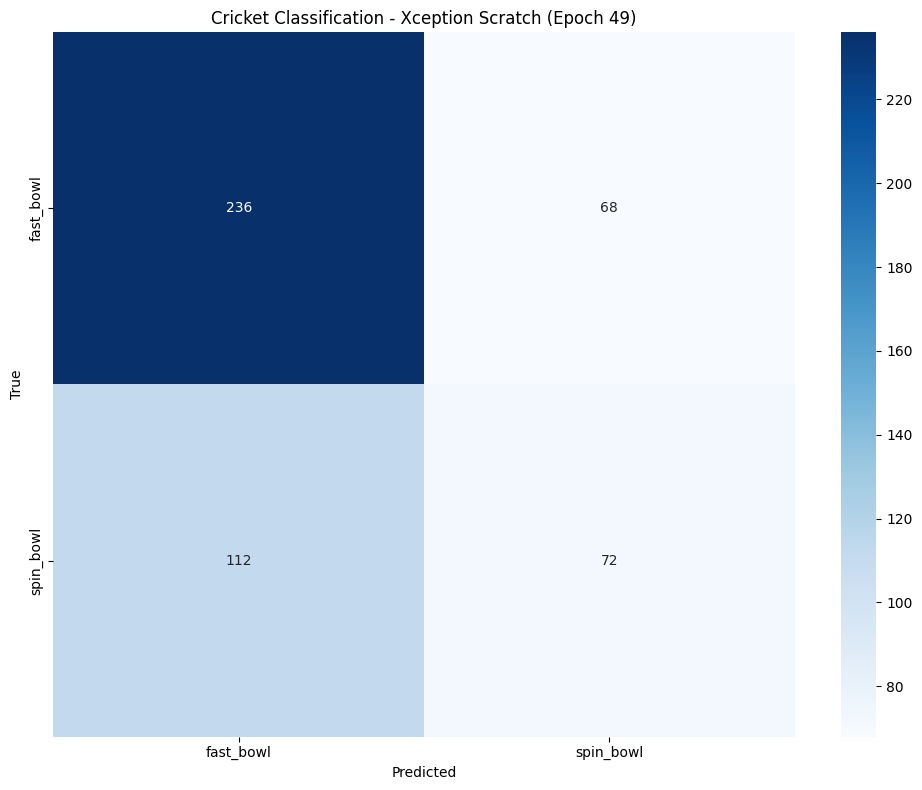

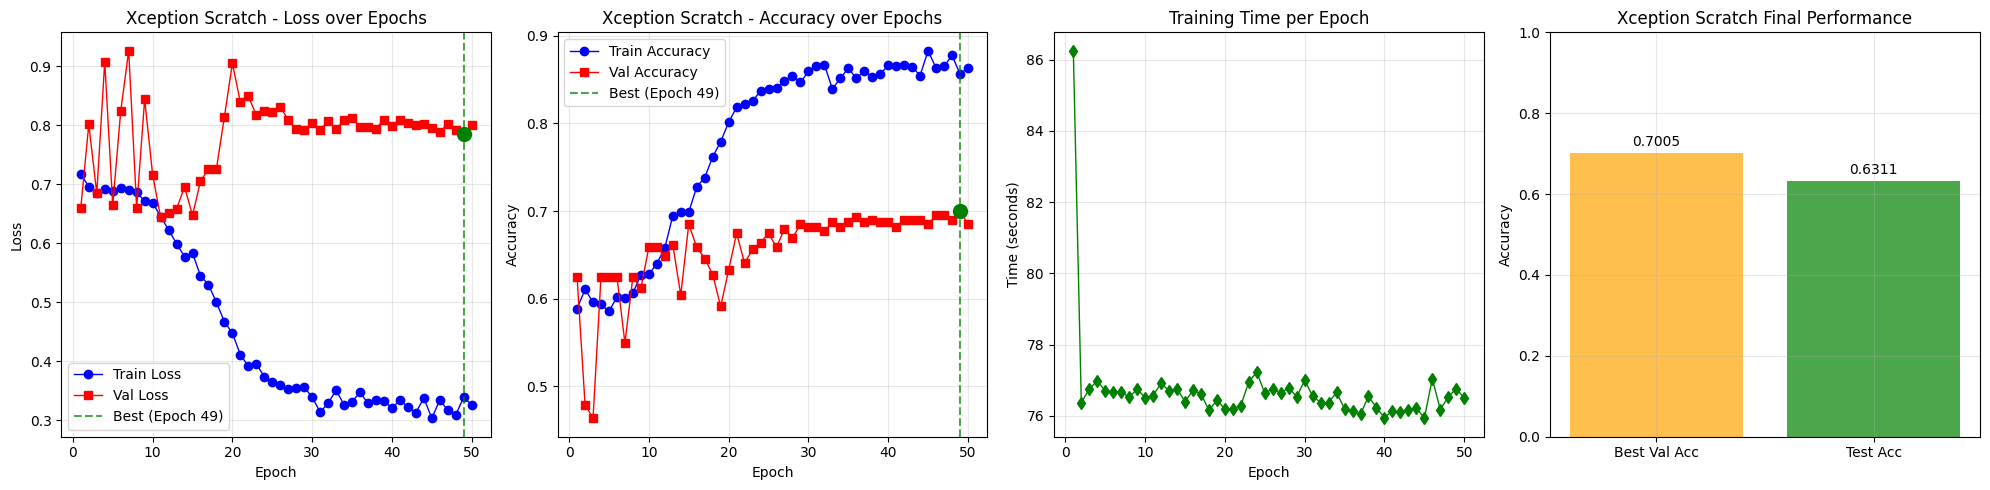


⏰ Final Timing Summary:
│ Total Training: 3835.28s (63.9 min)
│ Average per Epoch: 76.71s
│ Testing Time: 11.92s
│ Total Runtime: 3847.20s

🔀 Xception Scratch Training - Fixed Version:
│ ✅ Fixed inplace operations: All ReLU layers use inplace=False
│ ✅ Custom architecture: Built from ground up
│ ✅ Depthwise separable convolutions: Core Xception innovation
│ ✅ No transfer learning: Learns cricket features from scratch
│ ✅ Data augmentation: Robust training with limited data
│ ✅ Proper initialization: Xavier/He weight initialization
│ ✅ Learning rate scheduling: Adaptive learning rate decay
│ ✅ Clean dataset: 'random_occlusion' folder excluded
│ ✅ Gradient computation: Fixed backward pass issues


In [8]:

# -----------------------------
# 4. Training Setup for Scratch Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Higher LR for scratch training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

print(f"\n📋 Training Configuration:")
print(f"│ Model: Xception (from scratch)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Weight Decay: 1e-4")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 16")
print(f"│ LR Scheduler: StepLR (decay every 10 epochs)")
print(f"│ Device: {device}")
print(f"│ Data: Filtered + Augmented")

# -----------------------------
# 5. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50  # More epochs needed for scratch training

# Initialize best model tracking (using val_acc for scratch training)
best_val_acc = 0.0
best_model_state = None
best_epoch = 0
best_val_loss = float('inf')

print(f"\n🚀 Starting Xception Training from Scratch for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Update learning rate
    scheduler.step()
    
    # Check if this is the best model (using val_acc for scratch training)
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_xception_scratch_filtered.pth')
    print(f"\n💾 Best model saved as 'best_cricket_xception_scratch_filtered.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times,
    'learning_rate': [scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']] * epochs
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_xception_scratch_filtered_history.csv', index=False)
print("\n💾 Training history saved to 'cricket_xception_scratch_filtered_history.csv'")

print(f"\n🎉 Xception Scratch Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 6. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (Xception - Scratch Training):")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"│ Training Type: From scratch (no pretraining)")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_xception_scratch_filtered.pth - Best model weights")
print(f"│ cricket_xception_scratch_filtered_history.csv - Training metrics")

# -----------------------------
# 7. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Xception Scratch (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=1)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=1)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Scratch - Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=1)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=1)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Scratch - Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
plt.plot(range(1, epochs+1), epoch_times, 'g-', marker='d', linewidth=1)
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Xception Scratch Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Training Info
print(f"\n🔀 Xception Scratch Training - Fixed Version:")
print(f"│ ✅ Fixed inplace operations: All ReLU layers use inplace=False")
print(f"│ ✅ Custom architecture: Built from ground up")
print(f"│ ✅ Depthwise separable convolutions: Core Xception innovation")
print(f"│ ✅ No transfer learning: Learns cricket features from scratch")
print(f"│ ✅ Data augmentation: Robust training with limited data")
print(f"│ ✅ Proper initialization: Xavier/He weight initialization")
print(f"│ ✅ Learning rate scheduling: Adaptive learning rate decay")
print(f"│ ✅ Clean dataset: '{ignore_folder}' folder excluded")
print(f"│ ✅ Gradient computation: Fixed backward pass issues")